# Titanic
This notebook is my second attempt at building a classification model for the Titanic dataset ([here](https://github.com/iherman10/titanic/blob/main/titanic.ipynb) is my original). I'm building a new one after completing Chapter 3 of Hands-On Machine Learning, which went through the steps to build and evaluate classification models (using the MNIST dataset). 

I might reference code from Chapter 3 of Hands-On Machine Learning ([notebook](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)). 

# Frame the problem
This is a classification task, as we need to predict whether a passenger survived or not. 

## Measuring performance
There are several metrics we can use to measure the performance of a classification model. That being said, Kaggle ranks submissions for this dataset based on accuracy (% of correct predictions). Both _precision_ and _recall_ should be high in order to have a highly accurate model. We can stick with __accuracy__ for now. 

# Get the data
We have a couple files avilable: `train.csv` and `test.csv`. 

In [1]:
import pandas as pd 
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train.shape, test.shape

((891, 12), (418, 11))

# Explore the data

In [4]:
# Create copy to explore the data
explore = train.copy()

In [5]:
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Quick observations: 
- `PassengerID` is not useful 
- `Survived` is the target variable, should be stored separately in target/label array.  
- `Pclass` is really more of a categorical variable, can perform OneHot encoding on it, 
- `Age` has significant number of missing values which should be imputed. Also should be normalized/standardized. 
- `Ticket` is probably not so useful, unclear what the data really means there. 
- `Fare` should be normalized/standardized. 
- `Cabin` has too many missing values. This can be dropped. 
- `Embarked` can be OneHot encoded. 

In [6]:
explore.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [7]:
explore.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


__38% of passengers in this dataset survived__. So the positive class for our target variable is less common but not exceedingly rare. Meaning there isn't any explicit need to focus so heavily on precision/recall trade-off. 

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

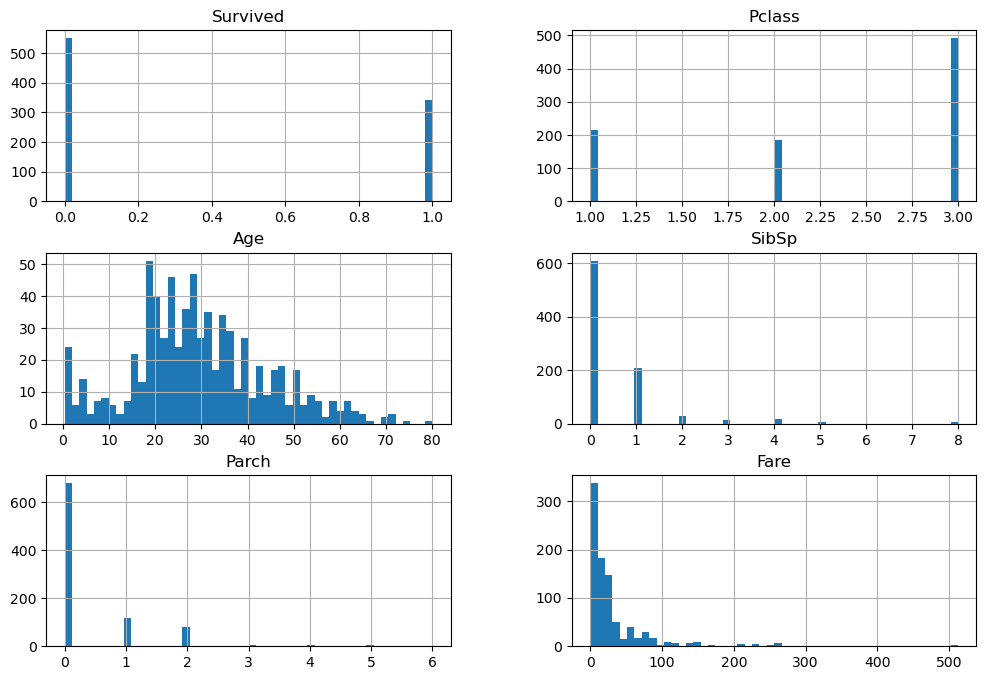

In [8]:
# Look at distributions
import matplotlib.pyplot as plt 

explore.hist(bins=50, figsize=(12, 8))

Potential numerical data transformations to explore: 

- Add total number of family members: `family = Parch + SibSP`. 
- Log-transform `Age` and `Fare`. 


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'family'}>,
        <Axes: title={'center': 'log_age'}>,
        <Axes: title={'center': 'log_fare'}>]], dtype=object)

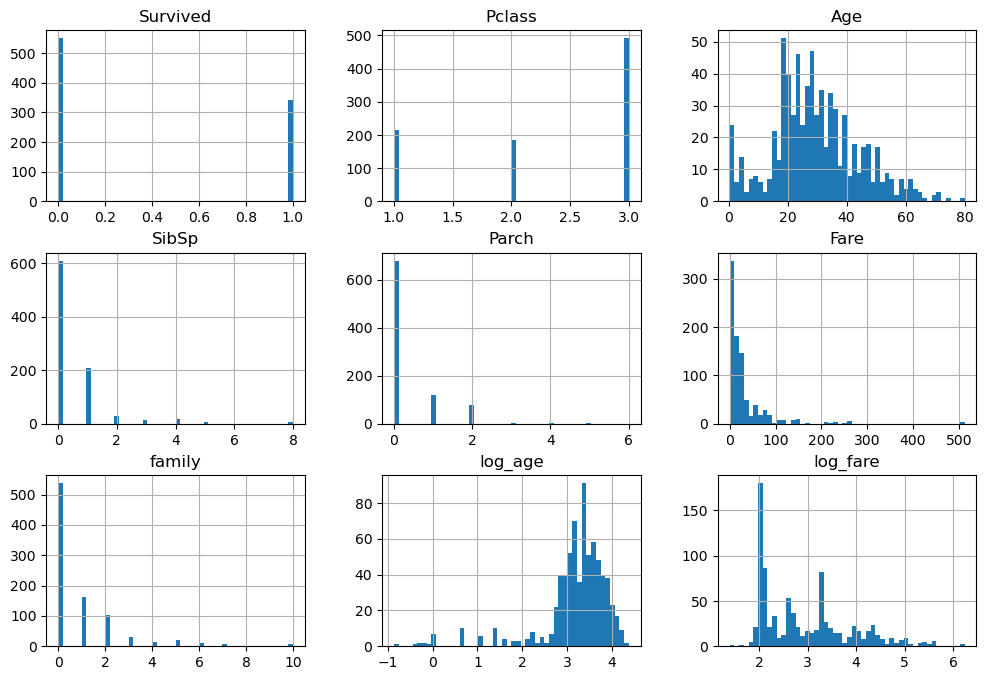

In [9]:
# Quick transformations 
import numpy as np
explore['family'] = explore['Parch'] + explore['SibSp']
explore['log_age'] = np.log(explore['Age'])
explore['log_fare'] = np.log(explore['Fare'].replace(0, np.nan))
explore.hist(bins=50, figsize=(12, 8))

In [10]:
# Look for correlations in the data
corr_matrix = explore.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
log_fare    0.325452
Fare        0.257307
Parch       0.081629
family      0.016639
SibSp      -0.035322
Age        -0.077221
log_age    -0.127863
Pclass     -0.338481
Name: Survived, dtype: float64

At first glance, `log_fare` is positively correlated with `Survived`, and `Pclass` is negatively correlated with `Survived`. Another variable of note is `log_age`, which is negatively correlated with `Survived`. 

On the surface, these relationships make directional sense. 
- If someone's fare is higher, they're likely wealthier and staying in a nicer cabin. Did these cabins also have more direct access to lifeboats? 
- `Pclass` has a similar possible explanation. The higher the number for `Pclass`, the lower the class is technically speaking. Maybe lower class cabins were closer to the bottom of the boat, further away from life boats. 
- It makes sense to think that younger passengers are more likely to survive. They're faster, stronger, etc. 

In [11]:
explore.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'family', 'log_age', 'log_fare'],
      dtype='object')

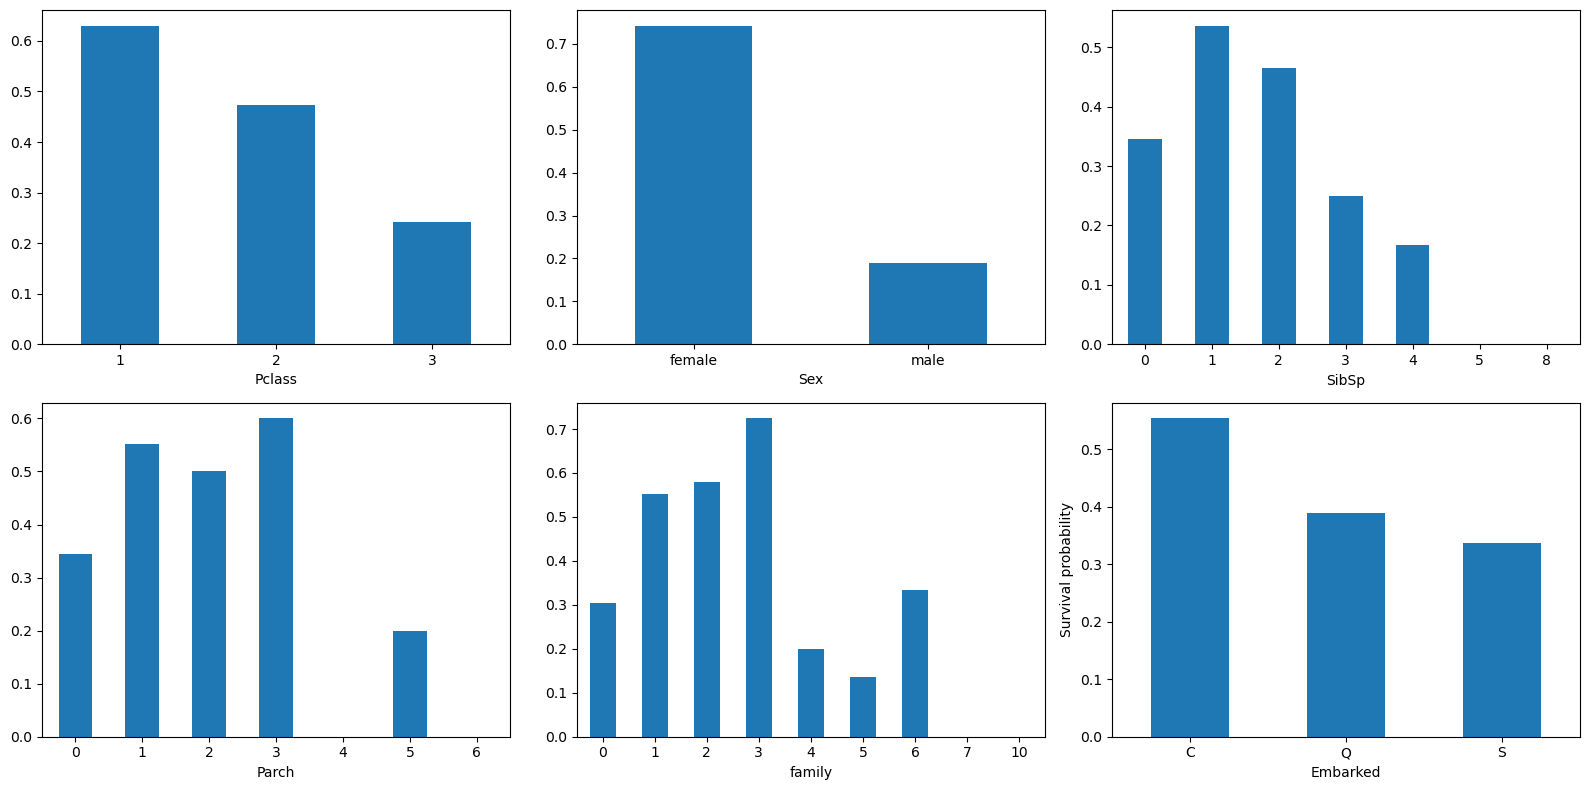

In [12]:
def plot_survival_probability(attribute, ax):
    grouped_df = explore.groupby(attribute)['Survived'].mean()
    grouped_df.plot(kind='bar', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')  
    plt.ylabel('Survival probability')

fig, axs = plt.subplots(2, 3, figsize=(16, 8))  
plot_survival_probability('Pclass', axs[0, 0])
plot_survival_probability('Sex', axs[0, 1])
plot_survival_probability('SibSp', axs[0, 2])
plot_survival_probability('Parch', axs[1, 0])
plot_survival_probability('family', axs[1, 1])
plot_survival_probability('Embarked', axs[1, 2])

plt.tight_layout()  
plt.show()  

From the above plots, we might be able to say the following passengers are more likely to survive: 
- Those in 1st class 
- Women 
- Had 3 family members on board (including parents, children, siblings, and spouses)
- Embarked from point 'C'

However, we haven't explored yet if there's significant correlation between these groups (e.g. more women in first class, or all first class passengers embarked at point 'C'). We can look at: 
1. Overlap of `Pclass` and `Sex`. 
2. Overlap of `Pclass` and `family`.  
3. Overlap of `Pclass` and `Embarked`.  

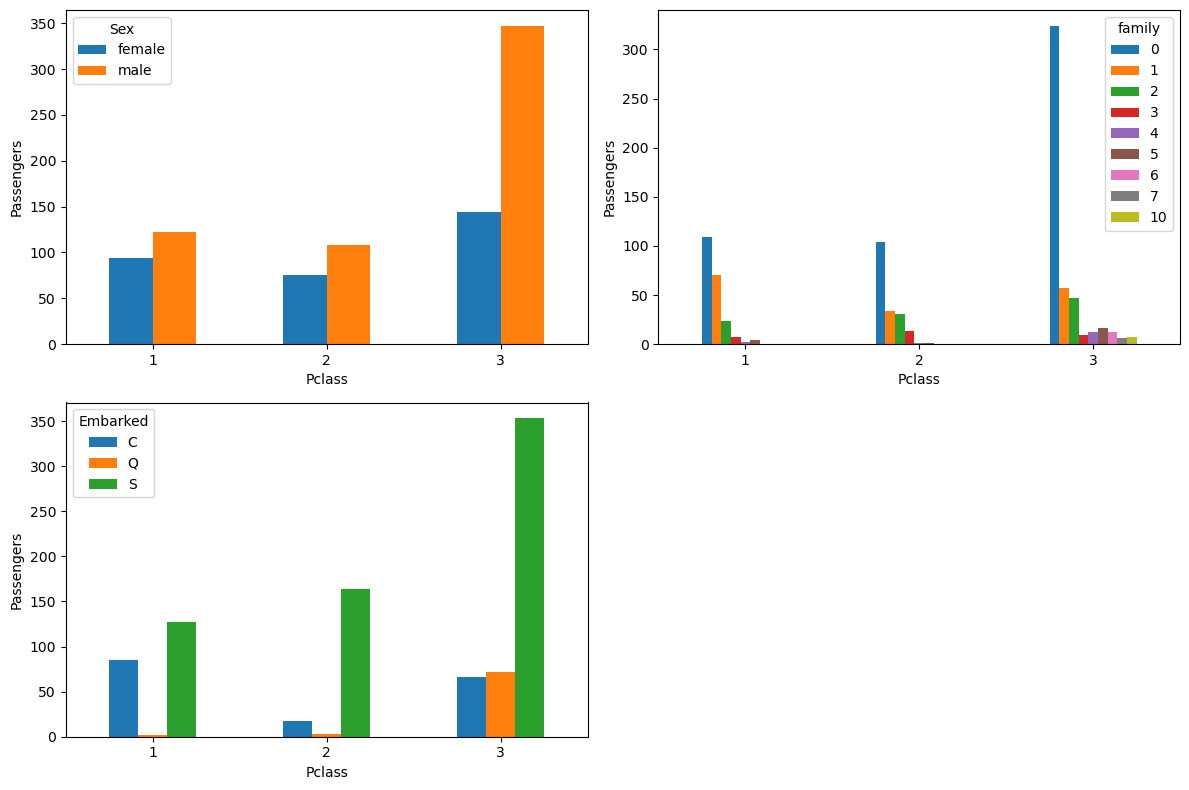

In [13]:
def plot_group_overlap(group_1, group_2, ax):  
    grouped_df = explore.groupby(group_1)[group_2].value_counts().unstack()  
    grouped_df.plot(kind='bar', ax=ax)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')  
    ax.set_ylabel('Passengers')  
    
  
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  
plot_group_overlap('Pclass', 'Sex', axs[0, 0])  
plot_group_overlap('Pclass', 'family', axs[0, 1])  
plot_group_overlap('Pclass', 'Embarked', axs[1, 0])  
  
# Remove the empty subplot  
fig.delaxes(axs[1, 1])  
  
plt.tight_layout()  
plt.show()  

There is some overlap obviously, but it's hard to say how this will impact the model ultimately: 
- 1st class has the highest percentage of women relatively. And 3rd class had the most men. 
- 3rd class had the most solo travelers (probably men). 
- Most 3rd class passengers embarked at point 'S', whereas most 1st class passengers embarked at point 'C'. 

So far we've primarily looked at the distribution of survivors across categorical attributes. What about the distribution of of different numerical attributes between those who survived vs. didn't? 

In [14]:
explore.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'family', 'log_age', 'log_fare'],
      dtype='object')

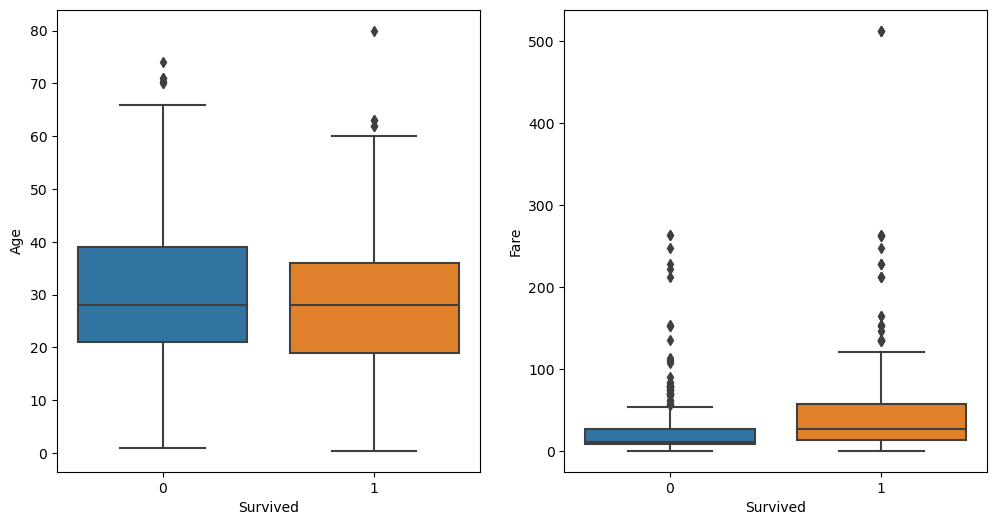

In [15]:
import seaborn as sns 
def plot_distribution(attribute, ax):
    sns.boxplot(data=explore, x='Survived', y=attribute, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
    
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  
plot_distribution('Age', axs[0])
plot_distribution('Fare', axs[1])

Not much here that we don't already know...

We can try another data transformation: extracting titles from names.

In [16]:
explore['title'] = explore['Name'].str.extract(', ([A-Za-z]+)\.', expand=False)
explore['title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Ms            1
Lady          1
Sir           1
Capt          1
Jonkheer      1
Name: title, dtype: int64

<Axes: xlabel='title', ylabel='count'>

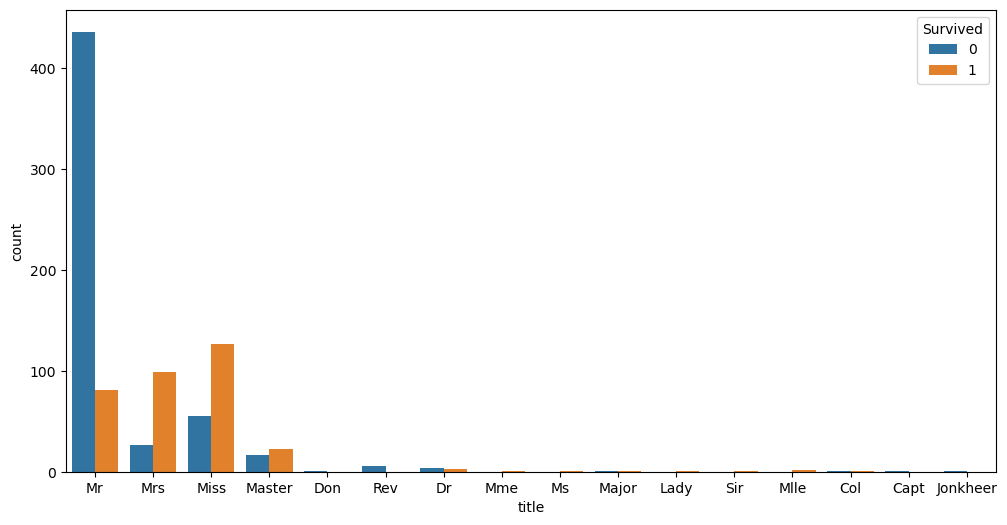

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(explore, x='title', hue='Survived')

We see that women passengers (those with title of Mrs. or Miss.) are more likely to survive. There's no other title group where this is true except for Master. By the sound of it, these were wealthy male passengers who likely had higher fares.

## Exploratory data analysis summary
- Attributes that are not necessary (can be dropped): `PassengerId, Ticket, Cabin`
- Numeric attributes most highly correlated with survival: 
    - `log_fare` (log transformation of `Fare`) is positively correlated w/ `Survived`. 
    - `log_age` (log transformation of `Age`) is negatively correlated w/ `Survived`. 
    -  `PClass` is negatively correlated w/ `Survived`. 
- Categorial attributes most highly correlated with survival: 
    - Women are the most likely to survive. 
    - Those with three family members on board (parents, children, siblings, spouses) are the most likely to survive. 
- Feature engineering possibilities: 
    - `family = Parch + SibSp` --> total number of family members onboard.
    - `title` --> extract title (e.g. 'Mr.', 'Mrs.') from `Name`
    
So to put this all in one sentence: __"If you were a wealthy woman with children onboard the titanic, you were most likely to survive."__

# Prepare the data

## Data cleaning and feature selection
Medium [article](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02#:~:text=Use%20StandardScaler%20if%20you%20want,to%20have%20a%20light%20touch.\) explaining difference between various scalers. Standard Scaler is the industry go-to. 

In [18]:
# Separate training and target data
X_train = train.drop('Survived', axis=1).copy()
y_train = train['Survived'].copy()

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [19]:
# Change Pclass to categorical type 
X_train['Pclass'] = X_train['Pclass'].astype('category')

In [20]:
# Only include columns I care about, remainders will be dropped from ColumnTransformer
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Pclass', 'Name', 'Sex', 'Embarked']

In [21]:
# Numerical transformer 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

class NumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_family=True, log_transform=True):
        self.add_family = add_family
        self.log_transform = log_transform
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_family:
            X['family'] = X['SibSp'] + X['Parch']
            
        if self.log_transform:
            X['log_age'] = np.log(np.where(X['Age']==0, 0.001, X['Age']))
            X['log_fare'] = np.log(np.where(X['Fare']==0, 0.001, X['Fare']))
            X = X.drop(['Age', 'Fare'], axis=1)
            
        return X
    def get_feature_names_out(self):
        pass

In [22]:
# Categorical transformer
import re

class CatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_title=True):
        self.add_title = add_title
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_title:
            X['title'] = X['Name'].apply(lambda name: re.search(', ([A-Za-z]+)\.', name).group(1) if re.search(', ([A-Za-z]+)\.', name) else None)
        
        X = X.drop(['Name'], axis=1)
        return X
    def get_feature_names_out(self):
        pass

In [23]:
# Create Pipeline objects 
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('num_transformer', NumTransformer()), 
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('cat_transfomer', CatTransformer()), 
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols), 
    ('cat', cat_pipeline, cat_cols)
])
full_pipeline.set_output(transform='pandas')
X_train_prepared = full_pipeline.fit_transform(X_train)

In [24]:
# Final columns in prepared dataset
X_train_prepared.columns

Index(['num__SibSp', 'num__Parch', 'num__family', 'num__log_age',
       'num__log_fare', 'cat__Pclass_1', 'cat__Pclass_2', 'cat__Pclass_3',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'cat__title_Capt',
       'cat__title_Col', 'cat__title_Don', 'cat__title_Dr',
       'cat__title_Jonkheer', 'cat__title_Lady', 'cat__title_Major',
       'cat__title_Master', 'cat__title_Miss', 'cat__title_Mlle',
       'cat__title_Mme', 'cat__title_Mr', 'cat__title_Mrs', 'cat__title_Ms',
       'cat__title_Rev', 'cat__title_Sir', 'cat__title_None'],
      dtype='object')

# Machine learning
## Try many different models
Models to test:
- Logistic regression (`from sklearn.linear_model import LogisticRegression`)
- Naive Bayes Classifier (`from sklearn.naive_bayes import GaussianNB`)
- k-Nearest Neighbors (`from sklearn.neighbors import KNeighborsClassifier`)
- Support Vector Machines (`from sklearn.svm import SVC`)
- Decision Trees (`from sklearn.tree import DecisionTreeClassifier`)
- Random Forests (`from sklearn.ensemble import RandomForestClassifier`)
- XGBoost (`from xgboost import XGBClassifier`)

In [25]:
# Utility function for model evaluation
def display_scores(scores):
    print(f"""
    Scores: {scores}
    Mean: {scores.mean()}
    Standard Deviation: {scores.std()}
    """)
    
# Utility functions to store/load models 
import joblib
def store_model(model, path):
    joblib.dump(model, f'new_models/{path}.joblib')
    
def load_model(path):
    return joblib.load(f'new_models/{path}.joblib')

In [26]:
# Logistic regression 
scores = {}
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
# logreg.fit(X_train_prepared, y_train)
# store_model(logreg, 'logreg')
logreg = load_model('logreg')

# Utility function to get mean CV score 
def get_mean_cv_score(model):
    scores = cross_val_score(model, X_train_prepared, y_train, scoring='accuracy', cv=10)
    return scores.mean()

logreg_mean_score = get_mean_cv_score(logreg)
scores['Logistic Regression'] = logreg_mean_score

In [27]:
# SVM
from sklearn.svm import SVC

svc = SVC()
# svc.fit(X_train_prepared, y_train)
# store_model(svc, 'svc')
svc = load_model('svc')

svc_mean_score = get_mean_cv_score(svc)
scores['Support Vector Machine'] = svc_mean_score

In [28]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
# tree.fit(X_train_prepared, y_train)
# store_model(tree, 'tree')
tree = load_model('tree')

tree_mean_score = get_mean_cv_score(tree)
scores['Decision Tree'] = tree_mean_score

In [29]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
# forest.fit(X_train_prepared, y_train)
# store_model(forest, 'forest')
forest = load_model('forest')

mean_forest_score = get_mean_cv_score(forest)
scores['Random Forest'] = mean_forest_score

In [30]:
# # XGBoost
# from xgboost import XGBClassifier

# xgb = XGBClassifier()
# xgb.fit(X_train_prepared, y_train)
# store_model(xgb, 'xgb')
# # xgb = load_model('xgb')

# xgb_mean_score = get_mean_cv_score(xgb)
# scores['XGBoost'] = xgb_mean_score

In [31]:
# KNN
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()
# knn.fit(X_train_prepared, y_train)
# store_model(knn, 'knn')
# knn = load_model('knn')
# knn.predict(X_train_prepared)
# knn_mean_score = get_mean_cv_score(knn)
# scores['knn'] = knn_mean_score

Text(0.5, 1.0, 'Model accuracy')

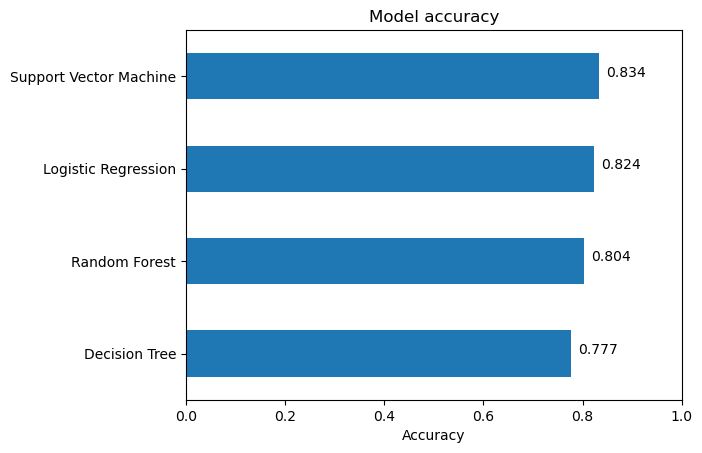

In [33]:
# Plot accuracy scores 
scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Accuracy'])
scores_df.sort_values('Accuracy', inplace=True)

scores_df.plot(kind='barh', legend=False)
plt.xlabel('Accuracy')
plt.xlim(0, 1)

# Add labels at the end of each bar  
for index, value in enumerate(scores_df['Accuracy']):  
    plt.annotate(f'{value:.3f}', (value, index), xytext=(5, 0), textcoords='offset points')  
    
plt.title('Model accuracy')

## Hyperparameter tuning on SVM model

In [45]:
# Randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

param_grid = {
    'C': reciprocal(0.1, 100),  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': reciprocal(0.01, 1.0),  
    'class_weight': [None, 'balanced']  
}

svc = SVC()
svc_rnd_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_grid, 
    n_iter=250, 
    cv=5, 
    scoring='accuracy', 
    verbose=3, 
    random_state=42
)

# svc_rnd_search.fit(X_train_prepared, y_train)
# store_model(svc_rnd_search, 'svc_rnd_search')
svc_rnd_search = load_model('svc_rnd_search')
print(f"""
SVC Randomized Search Mean CV Score (Best Estimator): {get_mean_cv_score(svc_rnd_search.best_estimator_)}
""")


SVC Randomized Search Mean CV Score (Best Estimator): 0.8338951310861423



In [49]:
# Grid search 
from sklearn.model_selection import GridSearchCV  

param_grid = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': [0.01, 0.1, 1.0],  
    'class_weight': [None, 'balanced']  
}

svc = SVC()
svc_grid_search = GridSearchCV(
    svc, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=3
)
# svc_grid_search.fit(X_train_prepared, y_train)
# store_model(svc_grid_search, 'svc_grid_search')
svc_grid_search = load_model('svc_grid_search')
print(f"""
SVC Randomized Search Mean CV Score (Best Estimator): {get_mean_cv_score(svc_grid_search.best_estimator_)}
""")


SVC Randomized Search Mean CV Score (Best Estimator): 0.8338826466916356



# Generate predictions on test set 


In [65]:
# Use randomized search best estimator 
X_test = test.copy()
X_test['Pclass'] = X_test['Pclass'].astype('category')
X_test_prepared = full_pipeline.transform(X_test)

predictions = svc_rnd_search.best_estimator_.predict(X_test_prepared)
predictions = pd.DataFrame(predictions, columns=['Survived'])

In [70]:
# Combine w passenger IDs for final submission
passenger_ids = X_test[['PassengerId']].copy()
submission = pd.concat([
    passenger_ids, 
    predictions
], axis=1)
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [71]:
submission.to_csv('submission.csv', index=False)